# Data fields



id - a unique identifier for each trip.

vendor_id - a code indicating the provider associated with the trip record.

pickup_datetime - date and time when the meter was engaged.

dropoff_datetime - date and time when the meter was disengaged.

passenger_count - the number of passengers in the vehicle (driver entered value).

pickup_longitude - the longitude where the meter was engaged.

pickup_latitude - the latitude where the meter was engaged.

dropoff_longitude - the longitude where the meter was disengaged.

dropoff_latitude - the latitude where the meter was disengaged.

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.

trip_duration - duration of the trip in seconds.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
import lux

In [3]:
data=pd.read_csv("nyc_taxi_trip_duration.csv")

In [4]:
data.head(10)


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [5]:
data.shape

(729322, 11)

In [6]:
data.info()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


In [7]:
data.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [8]:
# Checking dataset contains nulls or not
data.isnull().sum()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [9]:
data.store_and_fwd_flag.unique()

array(['N', 'Y'], dtype='<U1')

In [10]:
#Using Label encoder 
label=LabelEncoder()
data['store_and_fwd_flag'] = label.fit_transform(data['store_and_fwd_flag'])
data

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [11]:
## Other Methods

<Axes: >

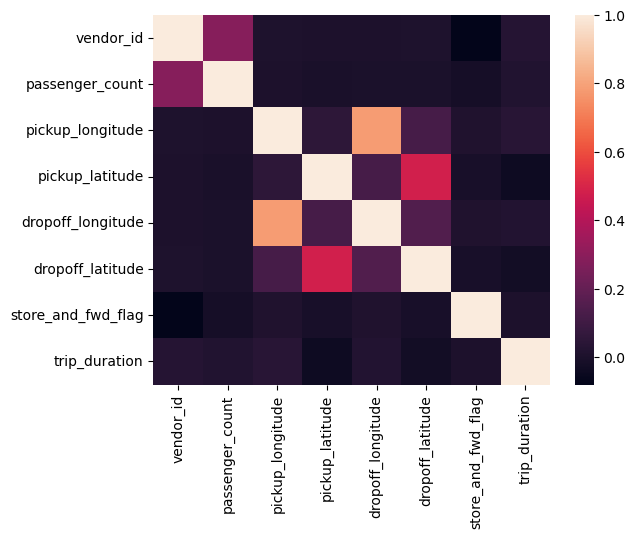

In [12]:

import seaborn as sns
correlation=data.corr()
sns.heatmap(correlation,linecolor='white',square=False)


trip_duration         1.000000
pickup_longitude      0.035447
vendor_id             0.027752
dropoff_longitude     0.020664
passenger_count       0.013022
store_and_fwd_flag    0.002754
dropoff_latitude     -0.028283
pickup_latitude      -0.038163
Name: trip_duration, dtype: float64


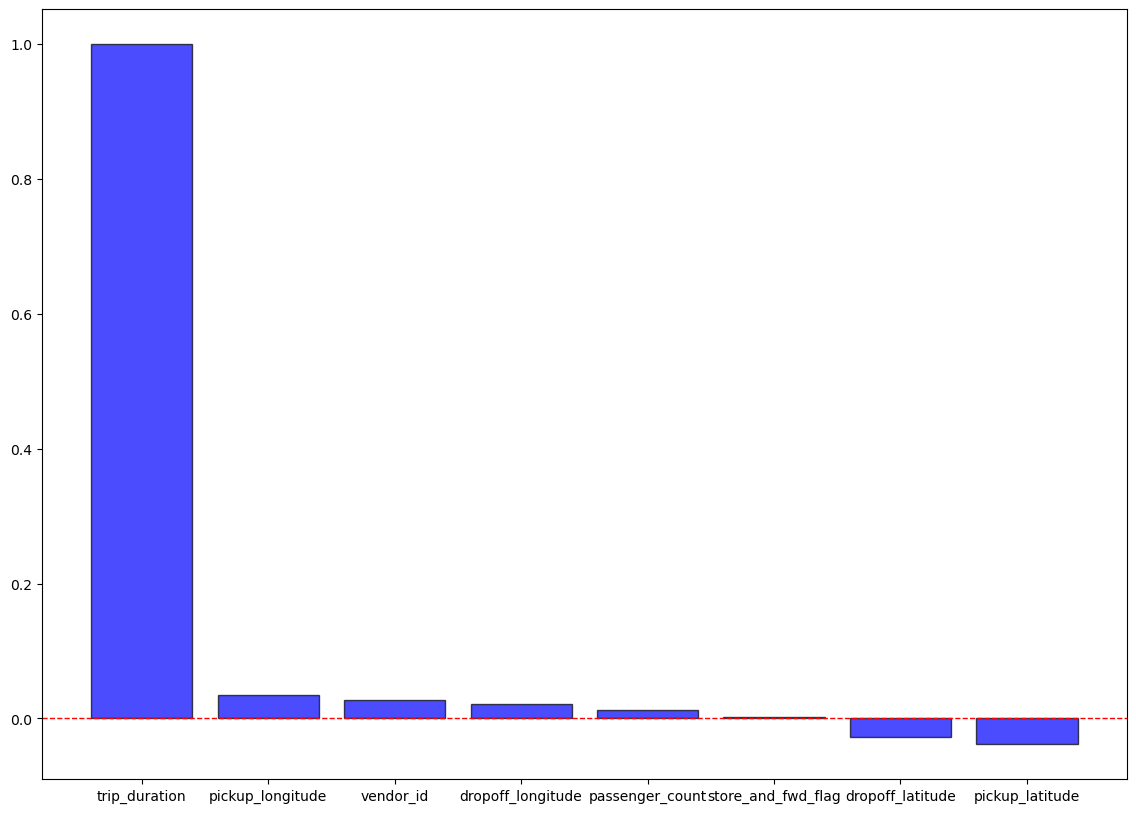

In [13]:
correlation_to_target=correlation['trip_duration'].sort_values(ascending=False)
print(correlation_to_target)
plt.figure(figsize=(14,10))
bars = plt.bar(x=correlation_to_target.index, height=correlation_to_target.values, color='blue', alpha=0.7, edgecolor='black')
plt.axhline(0, color='red', linewidth=1, linestyle='--') 

###  geodesic takes two tuples of latitude and longitude and calculates the shortest path between them on Earth’s surface, giving the distance in kilometers by default.

### Feature Engineering

In [14]:
from geopy.distance import geodesic
# Calculate distance using geodesic
data['distance_km'] = data.apply(lambda row: geodesic(
    (row['pickup_latitude'], row['pickup_longitude']),
    (row['dropoff_latitude'], row['dropoff_longitude'])
).kilometers, axis=1)

In [15]:
data["month"]=pd.to_datetime(data.pickup_datetime).dt.month
data["week"]=pd.to_datetime(data.pickup_datetime).dt.week
data["day"]=pd.to_datetime(data.pickup_datetime).dt.dayofweek
data["hour"]=pd.to_datetime(data.pickup_datetime).dt.hour

In [16]:

data=data.drop("id", axis=1)
data=data.drop('pickup_datetime',axis=1)
data=data.drop('dropoff_datetime',axis=1)

In [17]:
data

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [18]:
data.distance_km.max()

1240.5102556291924

In [19]:
data.distance_km.min()

0.0

In [20]:
pivot_table = pd.pivot_table(data, 
                             index='vendor_id', 
                             columns='passenger_count', 
                             values='distance_km', 
                             aggfunc='sum')
pivot_table

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [21]:
pivot_table = pivot_table.reset_index()
pivot_table

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [22]:
pivot_melted = pd.melt(pivot_table, id_vars=['vendor_id'], var_name='passenger_count', value_name='distance_km')
pivot_melted

,vendor_id,passenger_count,distance_km
0,1,0,55.476176
1,2,0,7.363948
2,1,1,908411.437833
3,2,1,843339.010677
4,1,2,180444.736822
5,2,2,204747.351860
6,1,3,42620.189111
7,2,3,62541.281721
8,1,4,23607.237422
9,2,4,27204.910168


<Axes: xlabel='passenger_count', ylabel='distance_km'>

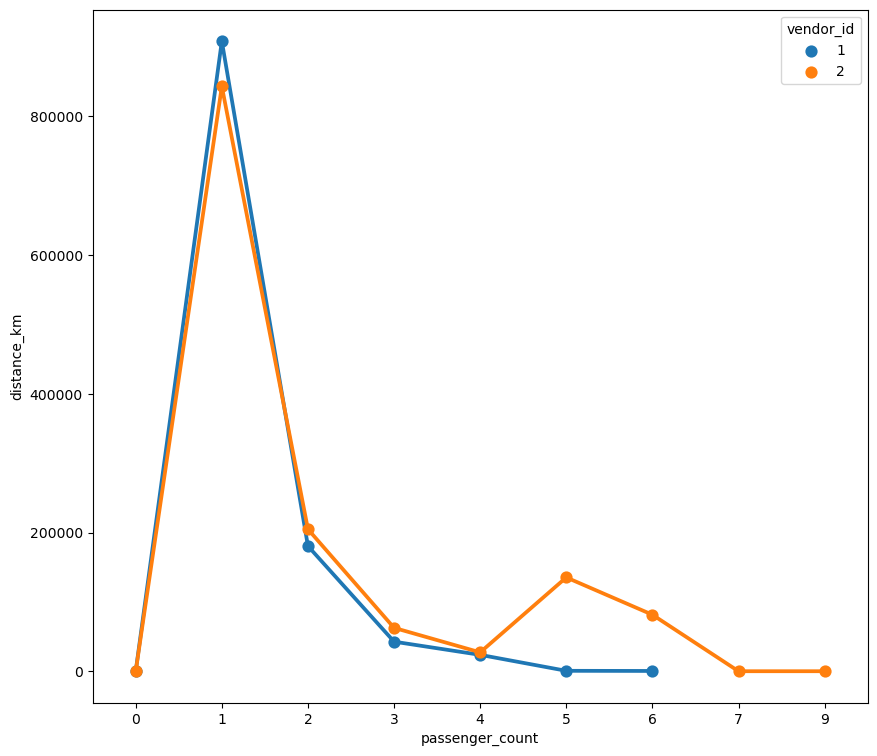

In [23]:
plt.figure(figsize=(10,9))
sns.pointplot(pivot_melted, x=pivot_melted.passenger_count, y='distance_km', hue='vendor_id')


In [24]:
data['trip_duration']

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [25]:
pivot2=pd.pivot_table(data,index='passenger_count',values='trip_duration',aggfunc='sum')
pivot2


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [26]:
pivot2=pivot2.reset_index()
pivot2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

<Axes: xlabel='passenger_count', ylabel='trip_duration'>

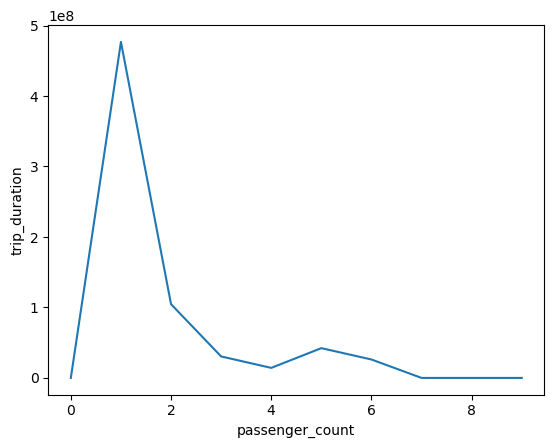

In [27]:
sns.lineplot(pivot2,x=pivot2.passenger_count,y=pivot2.trip_duration)

In [28]:
data.skew()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [29]:
correlations=data.corr()
correlation_to_target2=correlations['trip_duration'].sort_values(ascending=False)
correlation_to_target2

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

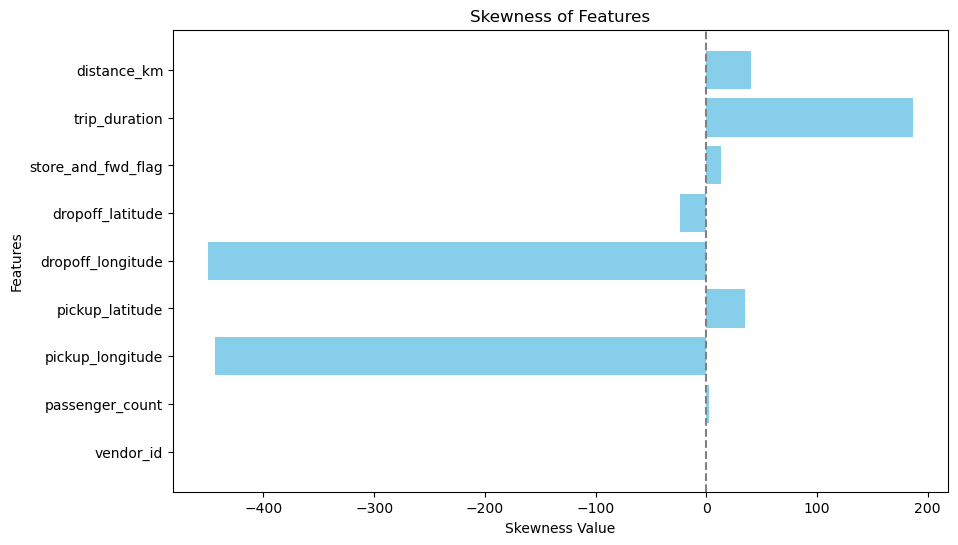

In [30]:
# Extract column names and skew values
skew_values = {
'vendor_id':     -0.141968,
'passenger_count':   2.135237,
'pickup_longitude':-444.219710,
'pickup_latitude'   :     35.369490,
'dropoff_longitude'  :  -449.890467,
'dropoff_latitude'    :  -23.503536,
'store_and_fwd_flag'   :  13.324097,
'trip_duration'         :186.678437,
 'distance_km' :           40.885947

}
columns = list(skew_values.keys())
values = list(skew_values.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(columns, values, color='skyblue')
plt.xlabel('Skewness Value')
plt.ylabel('Features')
plt.title('Skewness of Features')
plt.axvline(x=0, color='gray', linestyle='--')  # Vertical line at 0 to show symmetry
plt.show()

In [31]:
data=data.drop("pickup_longitude", axis=1)
data=data.drop("dropoff_longitude", axis=1)

### Making the log Transformation for minimizing the outliers

In [32]:
data['trip_duration'].min()

1

In [33]:
data['trip_duration'].max()

1939736

In [34]:
column=['trip_duration']


In [35]:
for i in column:
    data[i]=np.log(data[i]+1)

<Axes: xlabel='trip_duration', ylabel='Count'>

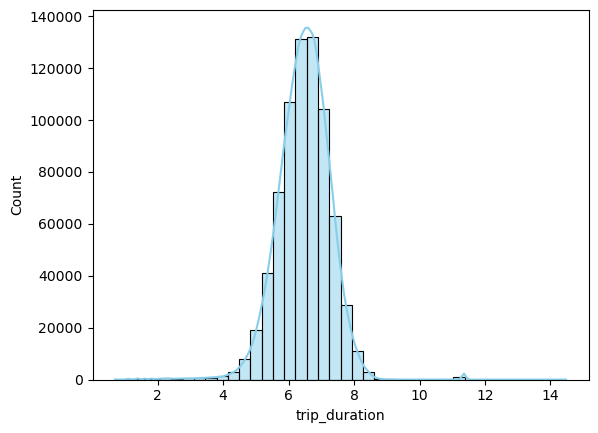

In [36]:
sns.histplot(data.trip_duration, kde=True, bins=40,color="skyblue", label="Trip Duration Data")


In [37]:
data.head(10)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [38]:
data.isnull().sum()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [39]:
data=data.drop('pickup_latitude',axis=1)
data=data.drop('dropoff_latitude',axis=1)

In [40]:

x=data.drop(columns='trip_duration', axis=1)
y=data["trip_duration"]

## Scaling 

In [41]:

x=data.drop(columns='trip_duration', axis=1)
y=data["trip_duration"]
from sklearn.preprocessing import StandardScaler
scaling= StandardScaler()
scaling=scaling.fit_transform(x)
scaling

array([[ 0.93153253, -0.50444382, -0.07463409, ..., -0.56598138,
        -1.56005656,  0.37300611],
       [-1.07349982,  0.25749304, -0.07463409, ..., -0.44913684,
         0.48653578,  1.46626948],
       [ 0.93153253,  0.25749304, -0.07463409, ..., -0.79967047,
         1.50983196,  0.5291866 ],
       ...,
       [-1.07349982, -0.50444382, -0.07463409, ...,  0.13508587,
         0.48653578,  0.68536708],
       [-1.07349982, -0.50444382, -0.07463409, ...,  1.18668675,
         1.50983196, -0.72025725],
       [ 0.93153253,  1.78136675, -0.07463409, ...,  4.57517848,
         0.48653578,  0.5291866 ]])

In [42]:
X=pd.DataFrame(scaling,columns=x.columns)

In [43]:
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.70,random_state=42)

In [44]:
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import LinearRegression

# Ridge


In [45]:
model= LinearRegression()
cross_val_score=cross_validate(model,X_train,y_train,cv=5)
cross_val_score

{'fit_time': array([0.09424138, 0.09430623, 0.09430552, 0.10409737, 0.10991597]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([-0.00266906,  0.36873433,  0.36459222,  0.36166839,  0.32867483])}

In [46]:
model=Ridge()
model.fit(X_train,y_train)
predition=model.predict(X_test)
r2=r2_score(y_test,predition)
msle=mean_squared_log_error(y_test,predition)
print("r2_score:", r2, "\nmean_squared_log_error:", msle)

r2_score: 0.36070550592696926 
mean_squared_log_error: 0.008589171848296542


# KNeighborsRegressor

In [47]:
from sklearn.neighbors import KNeighborsRegressor
knn=KNeighborsRegressor(n_neighbors=11)
knn.fit(X_train,y_train)
prediction2=knn.predict(X_test)
r2=r2_score(y_test,prediction2)
msle=mean_squared_log_error(y_test,prediction2)
print("r2_score:", r2, "\nmean_squared_log_error:", msle)

r2_score: 0.6127987173530591 
mean_squared_log_error: 0.005434313982117979


### Elbow curve

In [48]:
def curve(k):
    testloss=[]
    for i in k:
        reg=KNeighborsRegressor(n_neighbors=i)
        reg.fit(X_train,y_train)
        predit=reg.predict(X_test)
        mse=mean_squared_error(predit,y_test)
        testloss.append(mse)
    return testloss;

In [49]:
r=range(5,25,2)
test=curve(r)

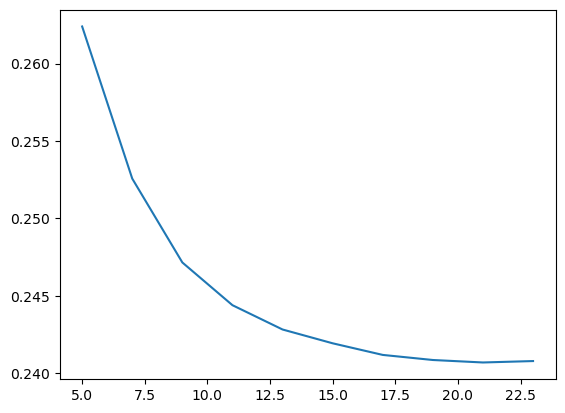

In [50]:
plt.plot(r,test)

# Light Gradient Boosting Machine

In [51]:
!pip install lightgbm 


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import lightgbm as lgb
# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'regression',  # Task is regression
    'metric': 'l2',             # Mean squared error
    'num_leaves': 31,           # Number of leaves in a tree
    'learning_rate': 0.05,      # Learning rate
    'feature_fraction': 0.9, 
    # Fraction of features to consider at each split
}

# Train the model
clf = lgb.train(params,
                train_data,
                valid_sets=[test_data], 
                num_boost_round=1000, 
                )

# Make predictions
y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
r2

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 510525, number of used features: 8
[LightGBM] [Info] Start training from score 6.467253


0.6647089520255848